# Wstępna analiza IUM
Rafał Bosko <br>

In [2]:
import jsonlines
import json
import pandas as pd
import math
import matplotlib.pyplot as plt

## Problem biznesowy
<blockquote>
Predykcja czy dana sesja użytkownika zakończy się zakupem na podstawie danych sesji. Skuteczna klasyfikacja sesji, które zakończą się zakupem umożliwi konsultantom szybsze rozwiązywanie problemów
</blockquote>

## Biznesowe kryterium sukcesu
System powinien przewidywać sesje, które zakończą się zakupem z efektywnością porównywalną z innymi istniejącymi rozwiązaniami wymienionymi w [literaturze](#literatura).

## Zadanie modelowania
Zadaniem jest klasyfikacja binarna odpowiadająca na pytanie "Czy sesja użytkownika zakończy się zakupem?".
Do dyspozycji mamy historyczne dane składające się z:
* bazy użytkowników
* katalogu produktów
* historia sesji
* dane dotyczące wysyłki zakupionych produktów

## Analityczne kryterium sukcesu
Uzyskanie odpowiednio wysokiej skuteczności predykcji mierzonej poprzez *Accuracy* obliczanej jako: 
$\frac{TP + TN}{TP + TN + FP + FN}$

Rozważaliśmy również *F1 score*, obliczanej jako: $2 * \frac{Precision * Recall}{Precision + Recall}$ gdzie: <br>
$Precision = \frac{TP}{TP + FP}$ oraz $Recall = \frac{TP}{TP + FN}$

Nie zdecydowaliśmy jednak wstępnie na tą miarę, ponieważ:
* jest trudniejsza do interpretacji
* F1 sprawdza się lepiej od Accuraccy w przypadku, gdy jest duża dysproporcja między klasami, a w naszym przypadku takiego problemu nie ma

## Analiza zbioru danych
Wstępna analiza danych pozwoliła nam odrzucić dane o przesyłkach, ponieważ te dane są dostarczane po zakupie i nie wpływają na zakup, podobna sytuacja dotyyczyła dwóch kolumn z tabeli sessions: typ zdarzenia i id zakupu, ponieważ to warość typu zdarzenia (zakup czy nie) będziemy przewidywali, a id zakupu jest ściśle skorelowane z typem zdarzenia.

Informacje zawarte w pozostałych tabelach są dostępne w trakcie trwania sesji, więc przeszliśmy do bardziej szczegółowej analizy tego fragmentu danych.

Postanowiliśmy wyróżnić ze zbioru danych następujące informacje:
* [*user_id*](#userId) - identyfikator użytkownika
* [*purchase*](#purchase) - wartość boolowska odpowiadająca na pytanie czy sesja zakończyła się zakupem
* [*offered_discount*](#discount) - wysokość zniżki
* [*item_views*](#item_views) - liczba obejrzanych przedmiotów w danej sesji
* [*unique_item_views*](#unique_item_views) - liczba przejrzanych unikalnych przedmiotów
* [*unique_categories*](#unique_categories) - liczba przejrzanych unikalnych kategorii

## Brakujące wartości
--do sprawdzenia--


In [3]:
def getDataFromJson(fileName):
    with open('../data/raw/'+fileName) as f:
        lines = f.read().splitlines()
    
    dataFrame = pd.DataFrame(lines)
    dataFrame.columns = ['json_element']
    return pd.json_normalize(dataFrame['json_element'].apply(json.loads))

## Przykładowe rekordy

In [4]:
# sessions = pd.read_csv("../data/processed/merged_dataset", sep=' ')
# sessions.head()
   
sessionsDataFrame = getDataFromJson('sessions.jsonl')

sessionsDataFrame.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,124,2021-05-26T01:18:01,102,1277,VIEW_PRODUCT,20,NaN
1,124,2021-05-26T01:19:32,102,1276,VIEW_PRODUCT,20,NaN
2,125,2021-07-16T14:16:04,102,1002,VIEW_PRODUCT,20,NaN
3,125,2021-07-16T14:17:23,102,1079,VIEW_PRODUCT,20,NaN
4,125,2021-07-16T14:19:23,102,1080,VIEW_PRODUCT,20,NaN


## Analiza ilościowa
Postanowiliśmy zbadać czy zbiór danych nie jest zdominowany przez sesje określonego typu: czy jest podobna
ilość tych które się zakończyły zakupem i tych w których do zakupu nie doszło:

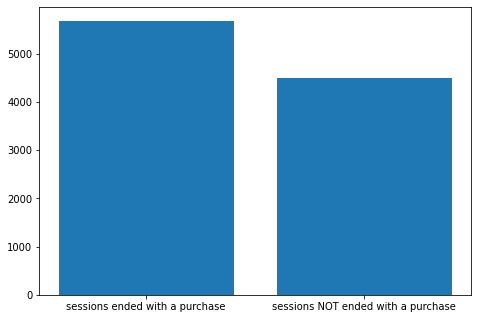

Różnica:  11.78%


In [25]:
sessionEndShopping = 0
sessionEndNotShopping = 0
sessionsDataFrame.sort_values(by=['session_id'])
sessions = []

for index, row in sessionsDataFrame.iterrows(): #merge session logs by id
    if len(sessions)==0:
        sessions.append([row['session_id'], row['event_type']])
    else:
        if sessions[len(sessions)-1][0] == row['session_id']:
            if sessions[len(sessions)-1][1] != 'BUY_PRODUCT':
                sessions[len(sessions)-1][1] = row['event_type']
        else:
            sessions.append([row['session_id'], row['event_type']])
   
for session in sessions:
    if session[1] == 'BUY_PRODUCT':
        sessionEndShopping += 1
    else:
        sessionEndNotShopping += 1
    
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['sessions ended with a purchase', 'sessions NOT ended with a purchase']
students = [sessionEndShopping,sessionEndNotShopping]
ax.bar(langs,students)
plt.show()

diff = abs(sessionEndNotShopping-sessionEndShopping)/(sessionEndShopping+sessionEndNotShopping)
print('Różnica:  '+str(round(diff*100, 2))+'%')


Okazuje się że znacząco sesji zakończonych zakupem jest nieco więcej, niż tych w których do zakupu nie doszło.

Postanowiliśmy sprawdzić ile unikalnych kategorii produktów mamy i jak się mają ich rozkłady

In [ ]:
sessionsDataFrame = getDataFromJson('products.jsonl')
# graph tree?